# Audio MFCC & Class Balance Checks

In [2]:
# Imports and plotting defaults
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

sns.set_theme(style="whitegrid")

In [3]:
# Load combined MFCC dataset and standardize language labels
data_path = Path("..") / "data" / "combined_mfcc(GTZAN+BanglaBeats)_30sec.csv"
df = pd.read_csv(data_path)

lang_lower = df["language"].astype(str).str.lower()
eng_mask = lang_lower.str.contains("eng")
df["language_group"] = np.where(eng_mask, "English (GTZAN)", "Bangla (BanglaBeats)")

display(df.head())
df["language_group"].value_counts()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,language,language_group
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,eng,English (GTZAN)
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,eng,English (GTZAN)
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,eng,English (GTZAN)
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,eng,English (GTZAN)
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,eng,English (GTZAN)


language_group
Bangla (BanglaBeats)    1617
English (GTZAN)         1000
Name: count, dtype: int64

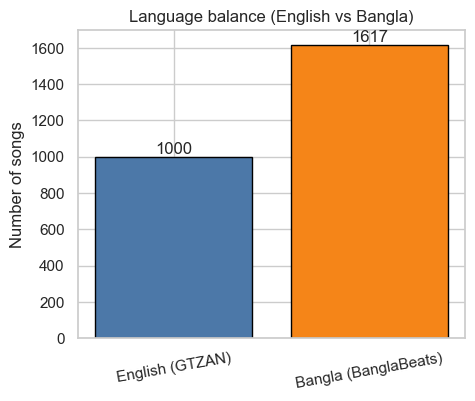

In [4]:
# Class distribution: English vs Bangla
counts = (
    df["language_group"].value_counts()
    .reindex(["English (GTZAN)", "Bangla (BanglaBeats)"])
    .fillna(0)
)

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(counts.index, counts.values, color=["#4C78A8", "#F58518"], edgecolor="black")
ax.set_ylabel("Number of songs")
ax.set_title("Language balance (English vs Bangla)")
ax.bar_label(bars, fmt="{:.0f}")
plt.xticks(rotation=10)
plt.show()

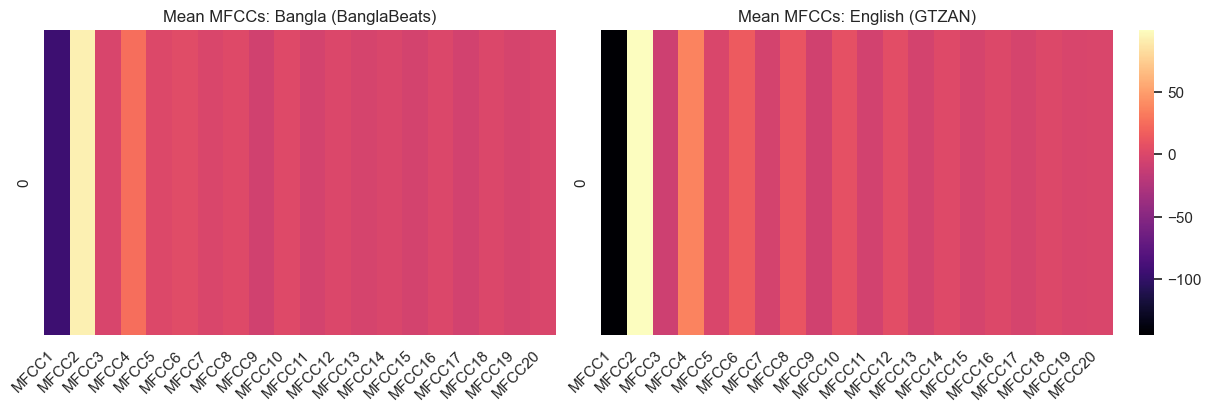

In [5]:
# Average MFCC heatmaps per language
mfcc_mean_cols = [c for c in df.columns if c.startswith("mfcc") and c.endswith("_mean")]
if not mfcc_mean_cols:
    print("No MFCC mean columns found.")
else:
    mean_by_lang = df.groupby("language_group")[mfcc_mean_cols].mean()
    # Keep a shared color scale so the two heatmaps are comparable
    vmin = mean_by_lang.values.min()
    vmax = mean_by_lang.values.max()

    fig, axes = plt.subplots(1, len(mean_by_lang), figsize=(12, 4), constrained_layout=True)
    if len(mean_by_lang) == 1:
        axes = [axes]

    for idx, (lang, row) in enumerate(mean_by_lang.iterrows()):
        coeff_labels = [c.replace("_mean", "").upper() for c in mfcc_mean_cols]
        data = pd.DataFrame([row.values], columns=coeff_labels)
        sns.heatmap(
            data,
            cmap="magma",
            ax=axes[idx],
            cbar=idx == len(mean_by_lang) - 1,
            vmin=vmin,
            vmax=vmax,
            annot=False,
        )
        axes[idx].set_title(f"Mean MFCCs: {lang}")
        axes[idx].set_ylabel("")
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha="right")
    plt.show()

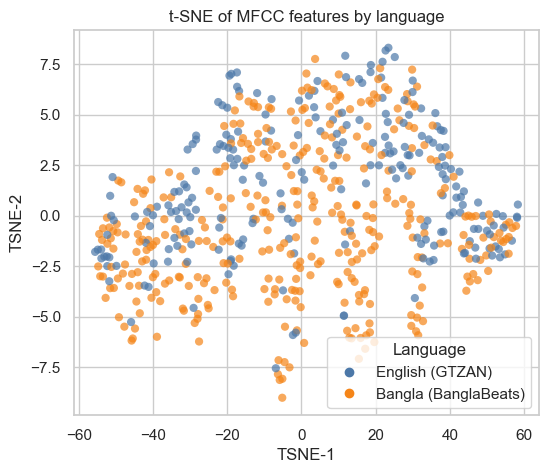

In [6]:
# t-SNE on MFCC features (flattened)
mfcc_cols = [c for c in df.columns if c.startswith("mfcc")]
usable = df.dropna(subset=mfcc_cols)
if len(usable) < 10:
    print("Not enough rows with complete MFCC data for t-SNE.")
else:
    sample_n = min(600, len(usable))
    sample = usable.sample(sample_n, random_state=42)
    features = sample[mfcc_cols].to_numpy()

    perplexity = max(5, min(30, features.shape[0] - 1))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate="auto",
        init="pca",
        random_state=42,
    )
    embedding = tsne.fit_transform(features)

    plt.figure(figsize=(6, 5))
    palette = {"English (GTZAN)": "#4C78A8", "Bangla (BanglaBeats)": "#F58518"}
    colors = sample["language_group"].map(palette)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, alpha=0.7, edgecolor="none", s=35)
    plt.title("t-SNE of MFCC features by language")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    handles = [plt.Line2D([], [], marker="o", linestyle="", color=color, label=label) for label, color in palette.items()]
    plt.legend(handles=handles, title="Language")
    plt.show()